<a href="https://colab.research.google.com/github/MaGariass/HWManageprogect/blob/main/HW_Wine_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Понимание бизнеса
##1.1 Цель
Предсказать качество вина

##1.2 Описание
Набор данных был загружен из репозитория машинного обучения UCI.

Данных относятся к красному и белому вариантам португальского вина "Винью Верде".  Из-за конфиденциальности и логистических проблем доступны только физико-химические (входные данные) и сенсорные (выходные данные) переменные (например, нет данных о сортах винограда, марке вина, отпускной цене вина и т.д.).

 Сорта упорядочены и не сбалансированы (например, нормальных вин гораздо больше, чем превосходных или некачественных). Алгоритмы обнаружения выбросов можно было бы использовать для выявления нескольких отличных или некачественных вин.




#2. Data Understanding
##2.1 Import Libraries

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier


# Modelling Helpers
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import  Normalizer , scale
from sklearn.model_selection import train_test_split , StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import GridSearchCV, cross_val_score 
from sklearn.pipeline import make_pipeline  
from sklearn.preprocessing import StandardScaler
import pickle

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

## 2.2 Вспомогательные функции

In [2]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))
    

def plot_var(df):
  fig, ax = plt.subplots(11, 2, figsize=(30, 80))
  for index, i in enumerate(df.select_dtypes(include=["float64"]).columns):
    sns.distplot(df[i], ax=ax[index, 0])
    sns.boxplot(df[i], ax=ax[index, 1])

  fig.tight_layout()
  fig.subplots_adjust(top=0.95)
  plt.suptitle("Visualizing columns", fontweight="bold", fontsize=40)

## 2.3 Загрузка данных

In [3]:
!wget https://raw.githubusercontent.com/MaGariass/HWManageprogect/main/files/wine

--2023-05-22 17:59:33--  https://raw.githubusercontent.com/MaGariass/HWManageprogect/main/files/wine
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 383878 (375K) [text/plain]
Saving to: ‘wine.1’

wine.1              100%[===================>] 374.88K  --.-KB/s    in 0.004s  

2023-05-22 17:59:33 (91.2 MB/s) - ‘wine.1’ saved [383878/383878]



In [4]:
df = pd.read_csv('wine', sep=';')

## 2.4 Статистика и визуализации

In [5]:
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


**Описание переменных**


*   fixed acidity - фиксированная кислотность
*   volatile acidity - летучая кислотность
*   citric acid - лимонная кислота
*   residual sugar - остаточный сахар
*   chlorides - хлориды
*   free sulfur dioxide - свободный диоксид серы
*   total sulfur dioxide - общий диоксид серы
*   density - плотность
*   pH
*   sulphates - сульфаты
*   alcohol - крепость
*   quality (score between 0 and 10) - качество(оценка от 0 до 10)

[Больше информации на сайте Kaggle](https://www.kaggle.com/datasets/rajyellow46/wine-quality)

### 2.4.1 Далее взглянем на некоторую ключевую информацию о переменных

In [6]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6487.000000,6489.000000,6494.000000,6495.000000,6495.000000,6497.000000,6497.000000,6497.000000,6488.000000,6493.000000,6497.000000,6497.000000
mean,7.216579,0.339691,0.318722,5.444326,0.056042,30.525319,115.744574,0.994697,3.218395,0.531215,10.491801,5.818378
std,1.296750,0.164649,0.145265,4.758125,0.035036,17.749400,56.521855,0.002999,0.160748,0.148814,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [7]:
df.info()#есть пропущенные значения

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


### 2.4.2 Тепловая карта корреляции может дать нам понимание того, какие переменные важны

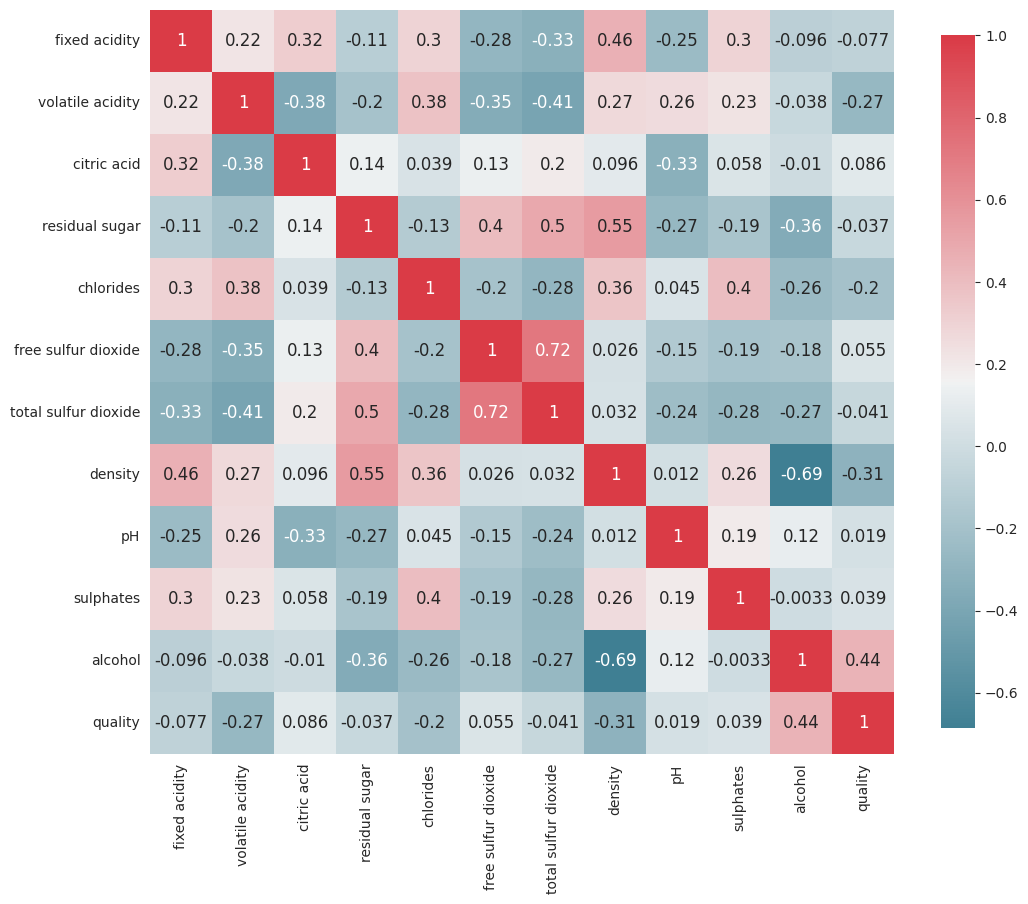

In [8]:
plot_correlation_map( df )

### 2.4.3 Давайте подробнее рассмотрим взаимосвязь между признаками и качеством вина

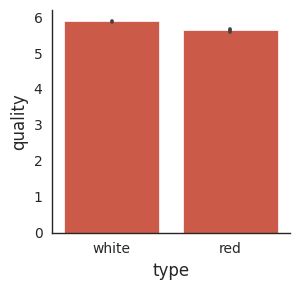

In [9]:
# Качество вина в зависимости от типа вина.
plot_categories( df , cat = 'type' , target = 'quality' )

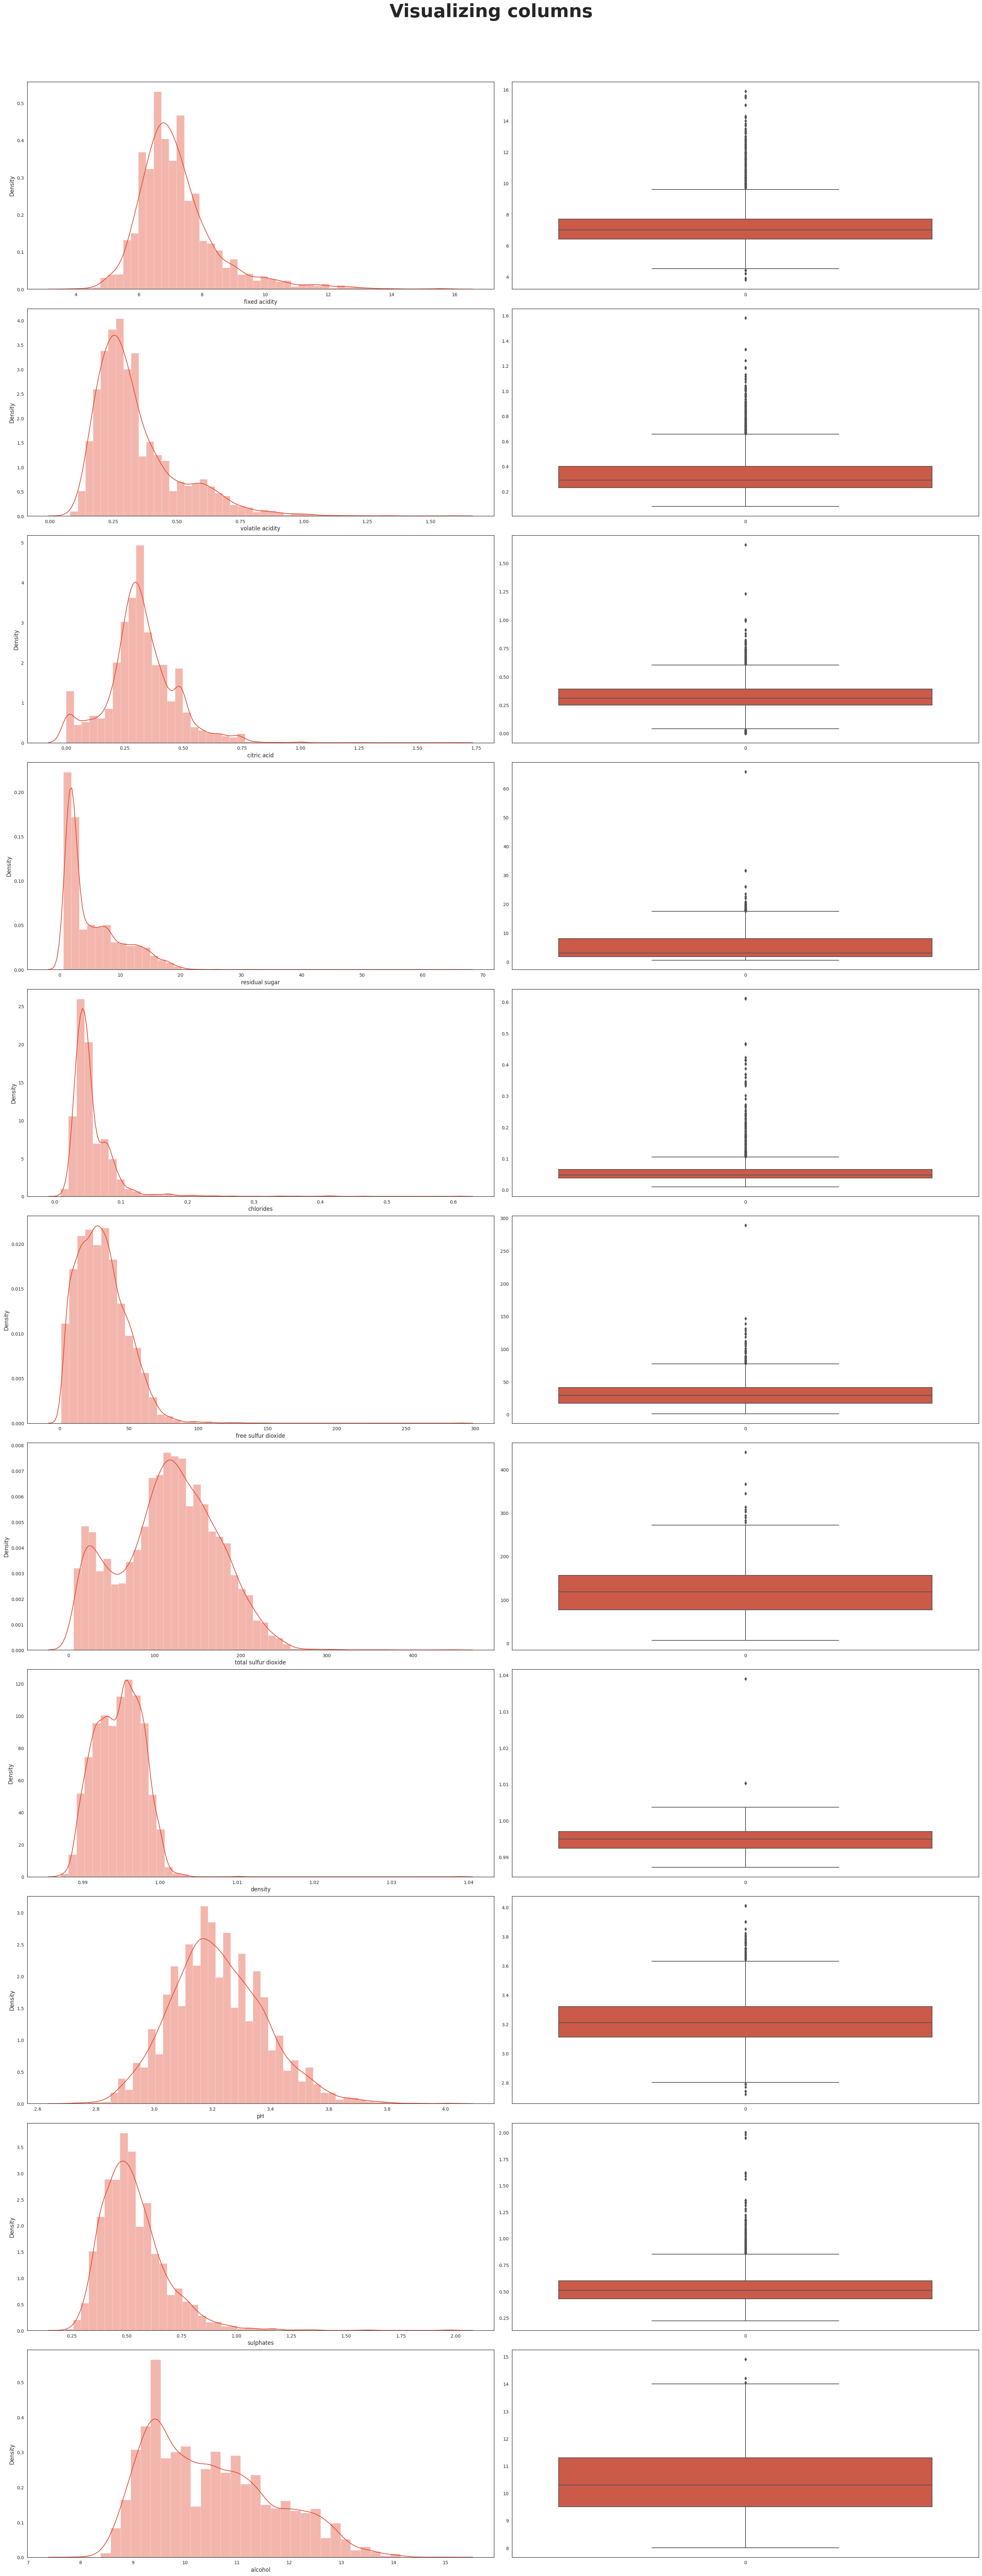

In [10]:
# Рассмотрим распределение
plot_var(df)

# 3. Data Preparation

## 3.1 Категориальные переменные должны быть преобразованы в числовые переменные

In [11]:
# Преобразуем тип вина.
type_ = pd.get_dummies(df, columns=['type'])
type_.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1


## 3.2 Заполним средним значение пропущенные значения в переменных

In [12]:
wine_filled = type_.fillna(df.mean())

In [13]:
wine_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type_red              6497 non-null   uint8  
 13  type_white            6497 non-null   uint8  
dtypes: float64(11), int64(1), uint8(2)
memory usage: 621.9 KB


## 3.4 Сборка финальных датасетов для моделирования

In [14]:
X =wine_filled.drop('quality', axis=1)
y = wine_filled['quality']

### 3.4.1 Создание датасетов

Отделяем данные для обучения и для проверки

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
X_train

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type_red,type_white
1916,6.6,0.25,0.36,8.1,0.045,54.0,180.0,0.99580,3.08,0.42,9.2,0,1
947,8.5,0.16,0.35,1.6,0.039,24.0,147.0,0.99350,2.96,0.36,10.0,0,1
877,6.0,0.28,0.34,1.6,0.119,33.0,104.0,0.99210,3.19,0.38,10.2,0,1
2927,7.0,0.31,0.31,9.1,0.036,45.0,140.0,0.99216,2.98,0.31,12.0,0,1
6063,8.5,0.44,0.50,1.9,0.369,15.0,38.0,0.99634,3.01,1.10,9.4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,6.3,0.24,0.29,13.7,0.035,53.0,134.0,0.99567,3.17,0.38,10.6,0,1
5191,6.9,0.36,0.25,2.4,0.098,5.0,16.0,0.99640,3.41,0.60,10.1,1,0
5226,13.4,0.27,0.62,2.6,0.082,6.0,21.0,1.00020,3.16,0.67,9.7,1,0
5390,8.9,0.40,0.51,2.6,0.052,13.0,27.0,0.99500,3.32,0.90,13.4,1,0


### 3.4.2 Важность признаков
Отбор оптимальных признаков для модели имеет важное значение. Теперь мы попытаемся оценить, какие переменные являются наиболее важными, чтобы сделать прогноз.

1.0


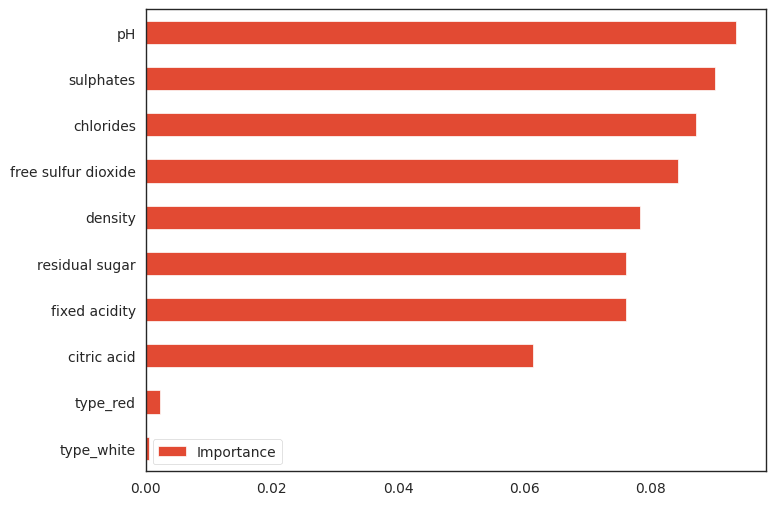

In [17]:
plot_variable_importance(X_train, y_train)

# 4. Моделирование
Теперь мы выберем модель, которую хотели бы попробовать. Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

## 4.1 Выбор модели
Хорошей отправной точкой является логистическая регрессия, но также рассмотрим еще 4. Данные стандартизируем.

In [18]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
models = [
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    KNeighborsClassifier(),
    SVC(random_state=42),
    LogisticRegression(random_state=42),
]

# 5. Оценка
Теперь мы собираемся оценить модель

## 5.1 Модель
Мы можем оценить точность модели, используя набор для валидации, где мы знаем фактический результат. Этот набор данных не использовался для обучения, поэтому он абсолютно новый для модели.

Затем мы сравниваем точность с точностью при использовании модели на тренировочных данных. Если разница между ними значительна, это свидетельствует о переобучении. Мы стараемся избегать этого, потому что это означает, что модель не будет хорошо обобщаться на новые данные (будет работать плохо)

In [20]:
models_comparison = {}

for model in models:
    print(f"Model: {str(model)}\n")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5)
    print(classification_report(y_test, y_pred))
    print("-" * 30, "\n")
    models_comparison[f"{str(model)}"] = [
        accuracy_score(y_pred, y_test),
        f1_score(y_pred, y_test, average="macro"),
        precision_score(y_pred, y_test, average="macro"),
        recall_score(y_pred, y_test, average="macro"),
        (accuracies.mean()),
    ]

Model: DecisionTreeClassifier(random_state=42)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.26      0.30      0.28        46
           5       0.67      0.68      0.67       420
           6       0.68      0.65      0.66       579
           7       0.51      0.52      0.51       221
           8       0.25      0.25      0.25        32
           9       0.00      0.00      0.00         0

    accuracy                           0.61      1300
   macro avg       0.34      0.34      0.34      1300
weighted avg       0.62      0.61      0.62      1300

------------------------------ 

Model: RandomForestClassifier(random_state=42)

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       1.00      0.13      0.23        46
           5       0.72      0.78      0.75       420
           6       0.68      0.78      0.73       579
   

In [21]:
models_com_df = pd.DataFrame(models_comparison).T
models_com_df.columns = [
    "Model Accuracy",
    "Model F1-Score",
    "Precision",
    "Recall",
    "CV Accuracy",
]
models_com_df = models_com_df.sort_values(by="Model F1-Score", ascending=False)
models_com_df.style.format("{:.2%}").background_gradient(cmap="Blues")

,Model Accuracy,Model F1-Score,Precision,Recall,CV Accuracy
RandomForestClassifier(random_state=42),69.77%,44.92%,40.87%,68.29%,65.96%
DecisionTreeClassifier(random_state=42),61.38%,34.06%,34.27%,33.88%,57.71%
KNeighborsClassifier(),55.62%,31.52%,30.48%,34.78%,54.44%
LogisticRegression(random_state=42),53.69%,26.20%,25.84%,35.77%,54.24%
SVC(random_state=42),58.00%,25.83%,26.56%,28.02%,57.09%


## 5.2 Вывод

Лучшие показатели у случайного леса.

## 5.3 Сохранеие результатов

In [22]:
with open('model.pkl','wb') as f:
    pickle.dump(model,f)

# 6. Подбор параметров
Теперь попробуем подобрать оптимальные параметры для модели

In [23]:
models_comparison2 = {}

### 6.1 Подбор параметров для RandomForestClassifier

In [24]:
parameters = {
    "n_estimators": [250, 500, 750, 1000],
    "max_depth": [16, 18, 20, 24, 26, 28, 30],
}

modelRF = RandomForestClassifier(random_state=42)

clfRF = GridSearchCV(modelRF, parameters, n_jobs=-1)
print("Searching for best hyperparameters...")
clfRF.fit(X_train, y_train)
y_pred = clfRF.predict(X_test)

modelRF = RandomForestClassifier(random_state=42, **clfRF.best_params_)

accuracies = cross_val_score(estimator=modelRF, X=X_train, y=y_train, cv=5)
models_comparison2["RandomForestClassifier"] = [
    accuracy_score(y_pred, y_test),
    f1_score(y_pred, y_test, average="macro"),
    precision_score(y_pred, y_test, average="macro"),
    recall_score(y_pred, y_test, average="macro"),
    (accuracies.mean()),
]

results_df = pd.DataFrame(clfRF.cv_results_)
results_df[["params", "mean_test_score"]].sort_values(
    "mean_test_score", ascending=False
).head(10)

Searching for best hyperparameters...


,params,mean_test_score
4,"{'max_depth': 18, 'n_estimators': 250}",0.670773
0,"{'max_depth': 16, 'n_estimators': 250}",0.668466
12,"{'max_depth': 24, 'n_estimators': 250}",0.667694
16,"{'max_depth': 26, 'n_estimators': 250}",0.667502
21,"{'max_depth': 28, 'n_estimators': 500}",0.666924
2,"{'max_depth': 16, 'n_estimators': 750}",0.666734
24,"{'max_depth': 30, 'n_estimators': 250}",0.666540
20,"{'max_depth': 28, 'n_estimators': 250}",0.666348
19,"{'max_depth': 26, 'n_estimators': 1000}",0.666348
25,"{'max_depth': 30, 'n_estimators': 500}",0.666347


### 6.2 Подбор параметров для DecisionTreeClassifier

In [25]:
parameters = {
    "max_depth": range(5, 26),
}

modelDT = DecisionTreeClassifier(random_state=42)

clfDT = GridSearchCV(modelDT, parameters, n_jobs=-1)
print("Searching for best hyperparameters...")
clfDT.fit(X_train, y_train)
y_pred = clfDT.predict(X_test)

modelDT = DecisionTreeClassifier(random_state=42, **clfDT.best_params_)

accuracies = cross_val_score(estimator=modelDT, X=X_train, y=y_train, cv=5)
models_comparison2["DecisionTreeClassifier"] = [
    accuracy_score(y_pred, y_test),
    f1_score(y_pred, y_test, average="macro"),
    precision_score(y_pred, y_test, average="macro"),
    recall_score(y_pred, y_test, average="macro"),
    (accuracies.mean()),
]

results_df = pd.DataFrame(clfDT.cv_results_)
results_df[["params", "mean_test_score"]].sort_values(
    "mean_test_score", ascending=False
).head(10)

Searching for best hyperparameters...


,params,mean_test_score
19,{'max_depth': 24},0.578028
20,{'max_depth': 25},0.576105
17,{'max_depth': 22},0.574755
18,{'max_depth': 23},0.573219
16,{'max_depth': 21},0.572256
15,{'max_depth': 20},0.569368
13,{'max_depth': 18},0.567634
14,{'max_depth': 19},0.566865
12,{'max_depth': 17},0.565326
11,{'max_depth': 16},0.563211


### 6.3 Подбор параметров для KNeighborsClassifier

In [26]:
parameters = {
    "n_neighbors": range(5, 50, 5),
    "weights": ["uniform", "distance"],
}

modelKC = KNeighborsClassifier()

clfKC = GridSearchCV(modelKC, parameters, n_jobs=-1)
print("Searching for best hyperparameters...")
clfKC.fit(X_train, y_train)
y_pred = clfKC.predict(X_test)

modelKC = KNeighborsClassifier(**clfKC.best_params_)

accuracies = cross_val_score(estimator=modelKC, X=X_train, y=y_train, cv=5)
models_comparison2["KNeighborsClassifier"] = [
    accuracy_score(y_pred, y_test),
    f1_score(y_pred, y_test, average="macro"),
    precision_score(y_pred, y_test, average="macro"),
    recall_score(y_pred, y_test, average="macro"),
    (accuracies.mean()),
]

results_df = pd.DataFrame(clfKC.cv_results_)
results_df[["params", "mean_test_score"]].sort_values(
    "mean_test_score", ascending=False
).head(10)

Searching for best hyperparameters...


,params,mean_test_score
11,"{'n_neighbors': 30, 'weights': 'distance'}",0.655188
9,"{'n_neighbors': 25, 'weights': 'distance'}",0.653649
13,"{'n_neighbors': 35, 'weights': 'distance'}",0.652303
7,"{'n_neighbors': 20, 'weights': 'distance'}",0.650957
15,"{'n_neighbors': 40, 'weights': 'distance'}",0.650571
17,"{'n_neighbors': 45, 'weights': 'distance'}",0.649994
5,"{'n_neighbors': 15, 'weights': 'distance'}",0.646916
3,"{'n_neighbors': 10, 'weights': 'distance'}",0.642489
1,"{'n_neighbors': 5, 'weights': 'distance'}",0.617860
8,"{'n_neighbors': 25, 'weights': 'uniform'}",0.553591


### 6.4 Подбор параметров для SVC

In [27]:
parameters = {
    "C": np.arange(0.1, 1, 0.2),
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
}

modelSVC = SVC(random_state=42)

clfSVC = GridSearchCV(modelSVC, parameters, n_jobs=-1)
print("Searching for best hyperparameters...")
clfSVC.fit(X_train, y_train)
y_pred = clfSVC.predict(X_test)

modelSVC = SVC(random_state=42, **clfSVC.best_params_)

accuracies = cross_val_score(estimator=modelSVC, X=X_train, y=y_train, cv=5)
models_comparison2["SVC"] = [
    accuracy_score(y_pred, y_test),
    f1_score(y_pred, y_test, average="macro"),
    precision_score(y_pred, y_test, average="macro"),
    recall_score(y_pred, y_test, average="macro"),
    (accuracies.mean()),
]

results_df = pd.DataFrame(clfSVC.cv_results_)
results_df[["params", "mean_test_score"]].sort_values(
    "mean_test_score", ascending=False
).head(10)

Searching for best hyperparameters...


,params,mean_test_score
18,"{'C': 0.9000000000000001, 'kernel': 'rbf'}",0.571098
14,"{'C': 0.7000000000000001, 'kernel': 'rbf'}",0.567827
10,"{'C': 0.5000000000000001, 'kernel': 'rbf'}",0.562824
6,"{'C': 0.30000000000000004, 'kernel': 'rbf'}",0.560322
2,"{'C': 0.1, 'kernel': 'rbf'}",0.537618
17,"{'C': 0.9000000000000001, 'kernel': 'poly'}",0.535122
4,"{'C': 0.30000000000000004, 'kernel': 'linear'}",0.533960
12,"{'C': 0.7000000000000001, 'kernel': 'linear'}",0.533768
16,"{'C': 0.9000000000000001, 'kernel': 'linear'}",0.533768
8,"{'C': 0.5000000000000001, 'kernel': 'linear'}",0.533575


### 6.5 Подбор параметров для LogisticRegression

In [28]:
parameters = {
    "C": np.arange(0.1, 1, 0.2),
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
}

modelLR = LogisticRegression(random_state=42, max_iter=100000)

clfLR = GridSearchCV(modelLR, parameters, n_jobs=-1)
print("Searching for best hyperparameters...")
clfLR.fit(X_train, y_train)
y_pred = clfLR.predict(X_test)

modelLR = LogisticRegression(random_state=42, max_iter=100000, **clfLR.best_params_)

accuracies = cross_val_score(estimator=modelLR, X=X_train, y=y_train, cv=5)
models_comparison2["LogisticRegression"] = [
    accuracy_score(y_pred, y_test),
    f1_score(y_pred, y_test, average="macro"),
    precision_score(y_pred, y_test, average="macro"),
    recall_score(y_pred, y_test, average="macro"),
    (accuracies.mean()),
]

results_df = pd.DataFrame(clfLR.cv_results_)
results_df[["params", "mean_test_score"]].sort_values(
    "mean_test_score", ascending=False
).head(10)

Searching for best hyperparameters...


,params,mean_test_score
14,"{'C': 0.5000000000000001, 'solver': 'saga'}",0.543195
13,"{'C': 0.5000000000000001, 'solver': 'sag'}",0.543195
10,"{'C': 0.5000000000000001, 'solver': 'newton-cg'}",0.543195
11,"{'C': 0.5000000000000001, 'solver': 'lbfgs'}",0.543195
19,"{'C': 0.7000000000000001, 'solver': 'saga'}",0.542618
16,"{'C': 0.7000000000000001, 'solver': 'lbfgs'}",0.542618
15,"{'C': 0.7000000000000001, 'solver': 'newton-cg'}",0.542618
18,"{'C': 0.7000000000000001, 'solver': 'sag'}",0.542618
9,"{'C': 0.30000000000000004, 'solver': 'saga'}",0.542618
5,"{'C': 0.30000000000000004, 'solver': 'newton-cg'}",0.542618


### 6.6 Сравнение результатов

In [29]:
models_com_df2 = pd.DataFrame(models_comparison2).T
models_com_df2.columns = [
    "Model Accuracy",
    "Model F1-Score",
    "Precision",
    "Recall",
    "CV Accuracy",
]
models_com_df2 = models_com_df2.sort_values(by="Model F1-Score", ascending=False)
models_com_df2.style.format("{:.2%}").background_gradient(cmap="Blues")

,Model Accuracy,Model F1-Score,Precision,Recall,CV Accuracy
RandomForestClassifier,70.08%,44.46%,40.50%,68.75%,67.08%
KNeighborsClassifier,68.69%,42.64%,39.30%,67.56%,65.52%
DecisionTreeClassifier,61.92%,34.69%,34.81%,34.60%,57.80%
LogisticRegression,53.62%,26.10%,25.77%,35.72%,54.32%
SVC,57.92%,25.59%,26.41%,27.97%,57.11%


Лучшие показатели также остались у случайного леса. На втором месте модель ближайших соседей.

### 6.7 Сохранение  результатов

In [30]:
with open('modelRF.pkl','wb') as f:
    pickle.dump(modelRF,f)

In [31]:
with open('modelDT.pkl','wb') as f:
    pickle.dump(modelDT,f)

In [32]:
with open('modelKC.pkl','wb') as f:
    pickle.dump(modelKC,f)

In [33]:
with open('modelSVC.pkl','wb') as f:
    pickle.dump(modelSVC,f)

In [34]:
with open('modelLR.pkl','wb') as f:
    pickle.dump(modelLR,f)